<a href="https://colab.research.google.com/github/nikhil16620/Nikz/blob/master/Dissertation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

df = pd.read_csv("/content/dataset.csv")

print(df.head())
print(df.info())
print(df.nunique())

  Transaction_ID    User_ID  Transaction_Amount Transaction_Type  \
0      TXN_33553  USER_1834               39.79              POS   
1       TXN_9427  USER_7875                1.19    Bank Transfer   
2        TXN_199  USER_2734               28.96           Online   
3      TXN_12447  USER_2617              254.32   ATM Withdrawal   
4      TXN_39489  USER_2014               31.28              POS   

             Timestamp  Account_Balance Device_Type  Location  \
0  2023-08-14 19:30:00         93213.17      Laptop    Sydney   
1  2023-06-07 04:01:00         75725.25      Mobile  New York   
2  2023-06-20 15:25:00          1588.96      Tablet    Mumbai   
3  2023-12-07 00:31:00         76807.20      Tablet  New York   
4  2023-11-11 23:44:00         92354.66      Mobile    Mumbai   

  Merchant_Category  IP_Address_Flag  ...  Daily_Transaction_Count  \
0            Travel                0  ...                        7   
1          Clothing                0  ...                   

In [2]:
# Target column - this is what we're trying to predict (fraud or not)
target_col = "Fraud_Label"  # 1 means fraud, 0 means legit transaction
id_cols = ["Transaction_ID"]  # Just the ID column for now





# Going through each ID column we listed
for c in id_cols:
    if c in df.columns:  # Making sure it actually exists first
        df = df.drop(columns=[c])  # Drop it from the dataframe




# 4. Now split everything into X (features) and y (what we want to predict)
X = df.drop(target_col, axis=1)  # Everything except the fraud label
y = df[target_col]  # Just the fraud labels



print("X shape:", X.shape)  # Should show (number of rows, number of features)
print("y value counts:\n", y.value_counts(normalize=True))  # Check class balance - important for fraud detection!




X shape: (50000, 19)
y value counts:
 Fraud_Label
0    0.67866
1    0.32134
Name: proportion, dtype: float64


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd  # Need this for working with dataframes




# 1. Split data into train and test sets
# Using stratify to keep the same fraud/non-fraud ratio in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,  # 80/20 split seems standard
    stratify=y,
    random_state=42  # For reproducibility
)




print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train fraud ratio:", y_train.mean())
print("Test fraud ratio:", y_test.mean())




# --- Cleaning up the data before we scale ---




# Get rid of User_ID - it's just a string identifier, doesn't help prediction
if 'User_ID' in X_train.columns:
    X_train = X_train.drop(columns=['User_ID'])
    X_test = X_test.drop(columns=['User_ID'])




if 'Timestamp' in X_train.columns:
    # Convert to datetime format first
    X_train['Timestamp'] = pd.to_datetime(X_train['Timestamp'])
    X_test['Timestamp'] = pd.to_datetime(X_test['Timestamp'])




    # Extract features t - fraud patterns could vary by time
    X_train['hour'] = X_train['Timestamp'].dt.hour
    X_train['dayofweek'] = X_train['Timestamp'].dt.dayofweek
    X_train['month'] = X_train['Timestamp'].dt.month
    X_train['dayofyear'] = X_train['Timestamp'].dt.dayofyear




    X_test['hour'] = X_test['Timestamp'].dt.hour
    X_test['dayofweek'] = X_test['Timestamp'].dt.dayofweek
    X_test['month'] = X_test['Timestamp'].dt.month
    X_test['dayofyear'] = X_test['Timestamp'].dt.dayofyear




    #  drop the original timestamp column
    X_train = X_train.drop(columns=['Timestamp'])
    X_test = X_test.drop(columns=['Timestamp'])




# Finding categorical columns
categorical_cols = X_train.select_dtypes(include='object').columns




# Convert categorical variables to numbers using one-hot encoding
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)




#  train and test have the same columns after encoding
train_cols = set(X_train.columns)
test_cols = set(X_test.columns)




# Add missing columns to test set with zeros
missing_in_test = list(train_cols - test_cols)
for c in missing_in_test:
    X_test[c] = 0




# Add missing columns to train set with zeros
missing_in_train = list(test_cols - train_cols)
for c in missing_in_train:
    X_train[c] = 0




# Make sure column order matches between train and test
X_test = X_test[X_train.columns]




# --- Done with preprocessing ---




# 2. Scale the features - helps logistic regression converge faster
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data only!
X_test_scaled = scaler.transform(X_test)  # Just transform test data with same scaler

Train shape: (40000, 19) Test shape: (10000, 19)
Train fraud ratio: 0.32135
Test fraud ratio: 0.3213


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score




# 1. Setting up our models - starting with baseline before trying SMOTE
# Logistic Regression - simple but effective
lr = LogisticRegression(
    max_iter=1000,  # Sometimes needs more iterations to converge
    class_weight="balanced",   # This should help with the imbalanced fraud data
    random_state=42
)




# Random Forest - usually performs better but takes longer to train
rf = RandomForestClassifier(
    n_estimators=300,  # More trees = better performance usually
    max_depth=None,
    class_weight="balanced",   # Again, dealing with class imbalance
    random_state=42,
    n_jobs=-1  # Use all CPU cores to speed things up
)




# 2. Train both models on our scaled data
print("Training Logistic Regression...")
lr.fit(X_train_scaled, y_train)

print("Training Random Forest...")
rf.fit(X_train_scaled, y_train)




# 3. Function to evaluate model performance

def evaluate_model(name, model, X_t, y_t):
    y_pred = model.predict(X_t)
    y_proba = model.predict_proba(X_t)[:, 1]  # Get probabilities for ROC-AUC

    print(f"\n=== {name} ===")
    print("Confusion matrix:\n", confusion_matrix(y_t, y_pred))
    print("Classification report:\n", classification_report(y_t, y_pred, digits=4))
    print("ROC-AUC:", roc_auc_score(y_t, y_proba))  # ROC-AUC is important for imbalanced datasets




# 4.  models perfomance on the test set
evaluate_model("Logistic Regression (baseline)", lr, X_test_scaled, y_test)
evaluate_model("Random Forest (baseline)", rf, X_test_scaled, y_test)

Training Logistic Regression...
Training Random Forest...

=== Logistic Regression (baseline) ===
Confusion matrix:
 [[5316 1471]
 [ 648 2565]]
Classification report:
               precision    recall  f1-score   support

           0     0.8913    0.7833    0.8338      6787
           1     0.6355    0.7983    0.7077      3213

    accuracy                         0.7881     10000
   macro avg     0.7634    0.7908    0.7708     10000
weighted avg     0.8092    0.7881    0.7933     10000

ROC-AUC: 0.8899894715511076

=== Random Forest (baseline) ===
Confusion matrix:
 [[6787    0]
 [   0 3213]]
Classification report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      6787
           1     1.0000    1.0000    1.0000      3213

    accuracy                         1.0000     10000
   macro avg     1.0000    1.0000    1.0000     10000
weighted avg     1.0000    1.0000    1.0000     10000

ROC-AUC: 1.0


In [5]:
from imblearn.over_sampling import SMOTE
import numpy as np

# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_scaled, y_train)

# check to see class distribution before/after
print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_sm))

# Setting up Logistic Regression
# Removed class_weight since SMOTE already handled the imbalance
lr_sm = LogisticRegression(
    max_iter=1000,
    class_weight=None,  # not needed anymore
    random_state=42
)

# Random Forest configuration
# Bumped n_estimators to 300 for better performance
rf_sm = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,      # let it grow as deep as needed
    class_weight=None,   # SMOTE took care of balancing
    random_state=42,
    n_jobs=-1            # use all CPU cores
)

# Train both models on the SMOTE-balanced data
lr_sm.fit(X_train_sm, y_train_sm)
rf_sm.fit(X_train_sm, y_train_sm)

# Evaluate performance on original test set
evaluate_model("Logistic Regression + SMOTE", lr_sm, X_test_scaled, y_test)
evaluate_model("Random Forest + SMOTE", rf_sm, X_test_scaled, y_test)

Before SMOTE: [27146 12854]
After SMOTE: [27146 27146]

=== Logistic Regression + SMOTE ===
Confusion matrix:
 [[5374 1413]
 [ 709 2504]]
Classification report:
               precision    recall  f1-score   support

           0     0.8834    0.7918    0.8351      6787
           1     0.6393    0.7793    0.7024      3213

    accuracy                         0.7878     10000
   macro avg     0.7614    0.7856    0.7688     10000
weighted avg     0.8050    0.7878    0.7925     10000

ROC-AUC: 0.8895213570587772

=== Random Forest + SMOTE ===
Confusion matrix:
 [[6787    0]
 [   0 3213]]
Classification report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      6787
           1     1.0000    1.0000    1.0000      3213

    accuracy                         1.0000     10000
   macro avg     1.0000    1.0000    1.0000     10000
weighted avg     1.0000    1.0000    1.0000     10000

ROC-AUC: 1.0


In [6]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Helper function to calculate all the metrics we care about
def get_metrics(name, model, X_t, y_t):
    # Get predictions
    y_pred = model.predict(X_t)
    y_proba = model.predict_proba(X_t)[:, 1]  # probabilities for positive class

    # Return everything as a dictionary
    return {
        "Model": name,
        "Precision": precision_score(y_t, y_pred),
        "Recall": recall_score(y_t, y_pred),
        "F1": f1_score(y_t, y_pred),
        "ROC_AUC": roc_auc_score(y_t, y_proba)
    }

# Collect metrics for all models
rows = []

# Baseline models first
rows.append(get_metrics("LR baseline", lr, X_test_scaled, y_test))
rows.append(get_metrics("RF baseline", rf, X_test_scaled, y_test))

# Then the SMOTE versions
rows.append(get_metrics("LR + SMOTE", lr_sm, X_test_scaled, y_test))
rows.append(get_metrics("RF + SMOTE", rf_sm, X_test_scaled, y_test))

# Put everything into a dataframe for easy comparison
results_df = pd.DataFrame(rows)
print(results_df)

         Model  Precision    Recall        F1   ROC_AUC
0  LR baseline   0.635530  0.798319  0.707684  0.889989
1  RF baseline   1.000000  1.000000  1.000000  1.000000
2   LR + SMOTE   0.639265  0.779334  0.702384  0.889521
3   RF + SMOTE   1.000000  1.000000  1.000000  1.000000


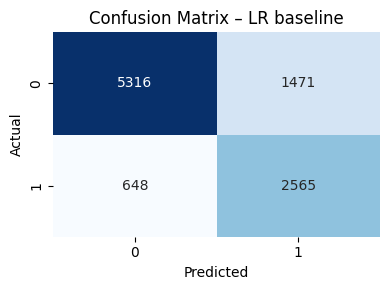

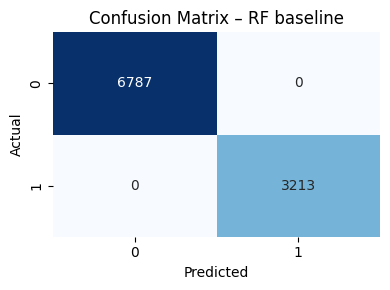

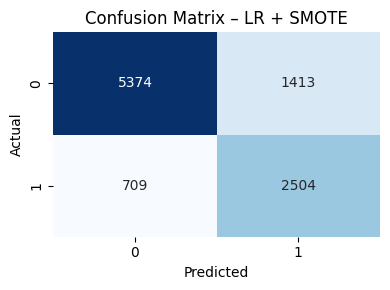

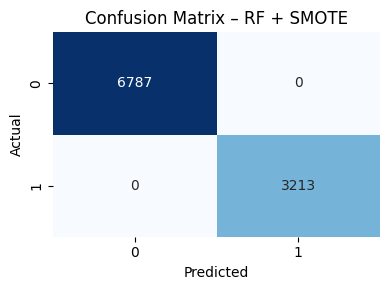

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to visualize confusion matrix for any model
def plot_conf_mat(name, model, X_t, y_t):
    # Generate predictions
    y_pred = model.predict(X_t)

    # Build the confusion matrix
    cm = confusion_matrix(y_t, y_pred)

    # Create figure - keeping it compact
    plt.figure(figsize=(4, 3))

    # Draw heatmap with annotations
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

    # Add labels and title
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    plt.tight_layout()  # make sure nothing gets cut off
    plt.show()

# Plot confusion matrices for all our models
# Starting with baseline models
plot_conf_mat("LR baseline", lr, X_test_scaled, y_test)
plot_conf_mat("RF baseline", rf, X_test_scaled, y_test)

# Now the SMOTE-enhanced versions
plot_conf_mat("LR + SMOTE", lr_sm, X_test_scaled, y_test)
plot_conf_mat("RF + SMOTE", rf_sm, X_test_scaled, y_test)

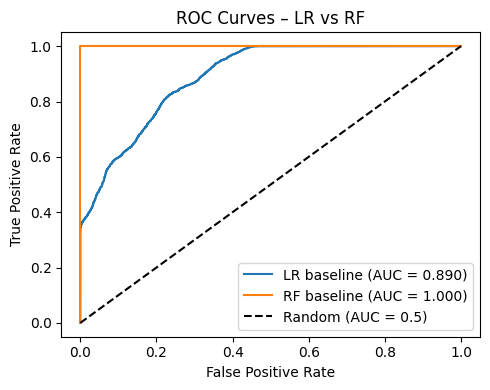

In [8]:
from sklearn.metrics import roc_curve, auc

def plot_roc_two(name1, model1, name2, model2, X_t, y_t):
    # Get predicted probabilities for positive class
    y_proba1 = model1.predict_proba(X_t)[:, 1]
    y_proba2 = model2.predict_proba(X_t)[:, 1]

    # Calculate ROC curve points for both models
    fpr1, tpr1, thresholds1 = roc_curve(y_t, y_proba1)
    fpr2, tpr2, thresholds2 = roc_curve(y_t, y_proba2)

    # Compute area under curve
    auc_score1 = auc(fpr1, tpr1)
    auc_score2 = auc(fpr2, tpr2)

    # Plot setup - using a slightly smaller figure for easier viewing
    plt.figure(figsize=(5, 4))

    # Plot first model ROC
    plt.plot(fpr1, tpr1, label=f"{name1} (AUC = {auc_score1:.3f})")

    # Plot second model ROC
    plt.plot(fpr2, tpr2, label=f"{name2} (AUC = {auc_score2:.3f})")

    # Add diagonal reference line (random classifier baseline)
    plt.plot([0, 1], [0, 1], "k--", label="Random (AUC = 0.5)")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves – LR vs RF")  # Keeping original title
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# Actually plot the comparison
plot_roc_two("LR baseline", lr, "RF baseline", rf, X_test_scaled, y_test)

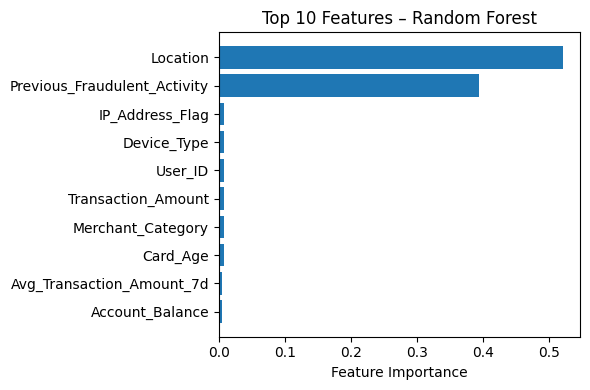

In [9]:
import numpy as np

def plot_rf_feature_importance(model, feature_names, top_n=10):
    # Extract feature importances from the trained model
    importances = model.feature_importances_

    # Get indices of top N most important features (sorted ascending, so we take last N)
    indices = np.argsort(importances)[-top_n:]

    # Create the plot
    plt.figure(figsize=(6, 4))

    # Horizontal bar chart works better for feature names readability
    plt.barh(range(len(indices)), importances[indices], align="center")

    # Set y-axis labels to actual feature names
    feature_labels = [feature_names[i] for i in indices]
    plt.yticks(range(len(indices)), feature_labels)

    plt.xlabel("Feature Importance")
    plt.title(f"Top {top_n} Features – Random Forest")

    plt.tight_layout()
    plt.show()

# Plot the top 10 most important features
plot_rf_feature_importance(rf, X.columns, top_n=10)